Load Video

1.   Load from Google Drive in Colab
2.   Make directory



In [ ]:
# # Google Colab import files in google drive
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools 

# !add-apt-repository -y ppa:alessandro-strada/ppa
  
# !apt-get update -qq

# !apt-get -y install -qq google-drive-ocamlfuse fuse 

# from google.colab import auth
# auth.authenticate_user()

# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()

# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# !mkdir -p drive
# !google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')

In [6]:
!dir "drive/My Drive/FaceClustering/"

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: C0A1-30B9

 C:\Users\Joonho Wohn\Documents\Dev\FaceClusterer\doomsheart\drive\My Drive\FaceClustering 디렉터리

2018-09-20  오후 08:29    <DIR>          .
2018-09-20  오후 08:29    <DIR>          ..
2018-09-20  오후 08:29    <DIR>          Cropped_imgs
2018-09-27  오후 03:12    <DIR>          res
2018-09-20  오후 08:28    <DIR>          Video
               0개 파일                   0 바이트
               5개 디렉터리  102,497,787,904 바이트 남음


In [7]:
!pip install tqdm
!pip install dlib
!pip install opencv-python
!pip install opencv-contrib-python
!pip install --upgrade imutils
!pip install cmake
!pip install dlib

from tqdm import tqdm
import cv2 as cv
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import shutil

VIDEO_DIR = 'drive/My Drive/FaceClustering/Video/'
VIDEO_FILE_NAME = 'PowerUp.mp4'
# PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
# PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d')
PROGRAM_START_TIME = '20180827'
SAVE_CROPPED_FACE_DIR = 'drive/My Drive/FaceClustering/result/Cropped_imgs/' + PROGRAM_START_TIME + '-' + VIDEO_FILE_NAME.split('.')[0]
RES_DIR = 'drive/My Drive/FaceClustering/res/'
CASCADE_DIR = 'drive/My Drive/FaceClustering/res/lbpcascade_frontalface_improved.xml'

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_RANDOM_CENTERS

def make_directory(_directory_name):
    if not os.path.exists(_directory_name):
        os.makedirs(_directory_name)
        
def get_area_of_frame_face_recognition(img, face_cascade):
    grayed_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # def detectMultiScale(self, image, scaleFactor=None, minNeighbors=None, flags=None, minSize=None, maxSize=None)
    face_area = face_cascade.detectMultiScale(image=grayed_img,scaleFactor=1.3,minNeighbors=5)
    return face_area
  
def get_frame(video_capture, frame):
    video_capture.set(cv.CAP_PROP_POS_FRAMES, frame)
    ret, img = video_capture.read()
    return img, frame, ret

def save_cropped_img(img, faces, frame):
    i = 0
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            iter = 0.2         
            while True:
                try:
                    face_img = img[int(y - h * iter): int(y + (1 + iter) * h),
                                   int(x - w * iter): int(x + (1 + iter) * w)]
                    if int(y - h * iter) < 0 or int(x - w * iter) < 0:
                        raise ValueError('range is false')
                    break
                except:
                    iter = iter * 0.8
                  #             cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", img[y:y + h, x: x + w])
            try:
                cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", cv.resize(face_img, (96, 96), interpolation=cv.INTER_AREA))
            except:
                print(int(y - h * iter))
                print(int(x - w * iter))
            i += 1

# this function show image and quit when press q or end
def show_img(img, faces):
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)
    cv.imshow('hello', img)
    if cv.waitKey(1) & 0xFF == ord('q'):
        return False
    else:
        return True
      
def ORB():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/130_0.jpg')
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img2 = None
    orb = cv.ORB_create()
    kp, des = orb.detectAndCompute(img, None)
#     img2 = cv.drawKeypoints(img, kp, img2, (0, 0, 255), flags=0)
#     plt.imshow(img2)
    return kp, des 

def HarrisCorner():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/130_0.jpg')
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(corners, cmap='gray')
    return coners

In [9]:
make_directory(SAVE_CROPPED_FACE_DIR)
m_video_capture = cv.VideoCapture(VIDEO_DIR + VIDEO_FILE_NAME)
m_face_cascade = cv.CascadeClassifier(CASCADE_DIR)
TOTAL_FRAME = m_video_capture.get(cv.CAP_PROP_FRAME_COUNT)
FRAME_STEP = 10
LOAD_FAIL = []
if len(os.listdir(SAVE_CROPPED_FACE_DIR)) == 0:
    for frame in tqdm(range(0, int(TOTAL_FRAME), FRAME_STEP)):
        img, frame, ret = get_frame(video_capture=m_video_capture, frame=frame)
        if not ret:
            LOAD_FAIL.append(frame)
            continue
        faces_area = get_area_of_frame_face_recognition(img=img, face_cascade=m_face_cascade)
        save_cropped_img(img, faces_area, frame)
    if len(LOAD_FAIL) > 0:
        print("Fail to load %d of frame(s)" % len(LOAD_FAIL))
        print(LOAD_FAIL)
else:    
    print("Directory is not empty")
    print("Already extracted in %s" % PROGRAM_START_TIME)

Directory is not empty
Already extracted in 20180827


In [10]:
SAVE_CROPPED_FACE_DIR

'drive/My Drive/FaceClustering/Cropped_imgs/20180827-PowerUp'

In [11]:
!dir "drive/My Drive/FaceClustering/Cropped_imgs/20180827-PowerUp/"

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: C0A1-30B9

 C:\Users\Joonho Wohn\Documents\Dev\FaceClusterer\doomsheart\drive\My Drive\FaceClustering\Cropped_imgs\20180827-PowerUp 디렉터리

2018-09-20  오후 08:31    <DIR>          .
2018-09-20  오후 08:31    <DIR>          ..
2018-09-20  오후 08:29             3,570 1000_0.jpg
2018-09-20  오후 08:29             4,238 1010_0.jpg
2018-09-20  오후 08:29             3,511 1010_1.jpg
2018-09-20  오후 08:29             3,515 1020_0.jpg
2018-09-20  오후 08:29             4,051 1020_1.jpg
2018-09-20  오후 08:29             5,526 1030_0.jpg
2018-09-20  오후 08:29             3,592 1030_1.jpg
2018-09-20  오후 08:29             3,910 1030_2.jpg
2018-09-20  오후 08:29             4,213 1090_0.jpg
2018-09-20  오후 08:30             3,312 1110_0.jpg
2018-09-20  오후 08:30             4,222 1200_0.jpg
2018-09-20  오후 08:29             4,688 120_0.jpg
2018-09-20  오후 08:30             4,088 1210_0.jpg
2018-09-20  오후 08:29             4,717 130_0.jpg
2018-09-20  오후 08:30             3,987 1340_0.

2018-09-20  오후 08:29             3,764 400_0.jpg
2018-09-20  오후 08:31             4,868 4030_0.jpg
2018-09-20  오후 08:31             4,709 4030_1.jpg
2018-09-20  오후 08:31             4,451 4050_0.jpg
2018-09-20  오후 08:31             4,831 4050_1.jpg
2018-09-20  오후 08:31             4,140 4050_2.jpg
2018-09-20  오후 08:31             4,315 4060_0.jpg
2018-09-20  오후 08:31             4,145 4070_0.jpg
2018-09-20  오후 08:31             5,192 4080_0.jpg
2018-09-20  오후 08:31             4,676 4090_0.jpg
2018-09-20  오후 08:31             5,096 4090_1.jpg
2018-09-20  오후 08:31             4,707 4090_2.jpg
2018-09-20  오후 08:31             4,516 4100_0.jpg
2018-09-20  오후 08:31             4,371 4100_1.jpg
2018-09-20  오후 08:31             4,818 4120_0.jpg
2018-09-20  오후 08:31             3,937 4300_0.jpg
2018-09-20  오후 08:29             3,555 430_0.jpg
2018-09-20  오후 08:31             4,388 4310_0.jpg
2018-09-20  오후 08:31             3,898 4320_0.jpg
2018-09-20  오후 08:31             4,065 4370_0.jpg
20

In [12]:
face_list = []
face_files = os.listdir(SAVE_CROPPED_FACE_DIR)

In [13]:
for face_file_name in tqdm(face_files):
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/' + face_file_name)
#     img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     img_blur = cv.GaussianBlur(img_gray, (3,3), 0)
#     img_sharp = cv.Laplacian(img_blur, cv.CV_64F)
#     corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
#     face_list.append(img_gray)
#     face_list.append(img_sharp.flatten())
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    face_list.append(rgb_img)

100%|███████████████████████████████████████████████████████████████████████████████| 223/223 [00:01<00:00, 132.40it/s]


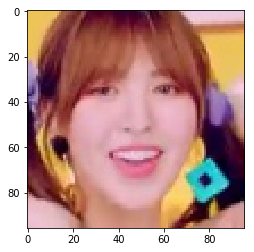

In [14]:
plt.imshow(face_list[5])

In [ ]:
import cv2
import numpy as np

# Read Image
im = face_list[5]
size = im.shape

#2D image points. If you change the image, you need to change vector
image_points = np.array([
                            (359, 391),     # Nose tip
                            (399, 561),     # Chin
                            (337, 297),     # Left eye left corner
                            (513, 301),     # Right eye right corne
                            (345, 465),     # Left Mouth corner
                            (453, 469)      # Right mouth corner
                        ], dtype="double")
 
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                         
                        ])

# Camera internals
 
focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
 
print("Camera Matrix :\n {0}".format(camera_matrix))
 
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.CV_ITERATIVE)
 
print ("Rotation Vector:\n {0}".format(rotation_vector))
print ("Translation Vector:\n {0}".format(translation_vector))

(nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
print(image_points)
for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 30, (0,255,255), -1)
 
 
p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
 
cv2.line(im, p1, p2, (255,0,0), 2)
 
# Display image
print(p1)
print(p2)
plt.imshow(im)

In [ ]:
# import the necessary packages
from imutils.video import VideoStream
from imutils import face_utils
import argparse
import imutils
import time
import dlib
import cv2
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--shape-predictor", required=True,
	help="path to facial landmark predictor")
args = vars(ap.parse_args())
# initialize dlib's face detector (HOG-based) and then create the
# facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])
 
# initialize the video stream and sleep for a bit, allowing the
# camera sensor to warm up
print("[INFO] camera sensor warming up...")
vs = VideoStream(src=1).start()
# vs = VideoStream(usePiCamera=True).start() # Raspberry Pi
time.sleep(2.0)
# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream, resize it to
	# have a maximum width of 400 pixels, and convert it to
	# grayscale
	frame = vs.read()
	frame = imutils.resize(frame, width=400)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
	# detect faces in the grayscale frame
	rects = detector(gray, 0)
 
	# check to see if a face was detected, and if so, draw the total
	# number of faces on the frame
	if len(rects) > 0:
		text = "{} face(s) found".format(len(rects))
		cv2.putText(frame, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, (0, 0, 255), 2)
        	# loop over the face detections
	for rect in rects:
		# compute the bounding box of the face and draw it on the
		# frame
		(bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
		cv2.rectangle(frame, (bX, bY), (bX + bW, bY + bH),
			(0, 255, 0), 1)
 
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
 
		# loop over the (x, y)-coordinates for the facial landmarks
		# and draw each of them
		for (i, (x, y)) in enumerate(shape):
			cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
			cv2.putText(frame, str(i + 1), (x - 10, y - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
            	# show the frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
 
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
 
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

In [ ]:
plt.imshow(face_list[10])

In [ ]:
rotation = cv.getRotationMatrix2D((40, 40), 5, 1) # 1은 확대/축소값입니다.
result = cv.warpAffine(face_list[10], rotation, (face_list[10].shape[:2]))

In [ ]:
plt.imshow(result)

In [ ]:
face_list = np.float32(face_list)

In [ ]:
compactness = []
kvals = np.arange(1,10)
for k in tqdm(kvals):
    c, _, _ =  cv.kmeans(face_list, k, None, criteria, 10, flags)
    compactness.append(c)
plt.plot(kvals, compactness, 'o-', linewidth=4,
        markersize=12)
plt.xlabel('number of clusters')
plt.ylabel('compactness')

In [ ]:
k = 4
compactness, clusters, centers = cv.kmeans(face_list, k, None, criteria, 10, flags)
make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k))
for i in range(k):
    make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(i))

In [ ]:
for f_n, c_k in tqdm(zip(face_files, clusters)):
    print(f_n, c_k )
    shutil.copy2(SAVE_CROPPED_FACE_DIR + '/' + f_n, SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(c_k[0]) + '/' + f_n)

In [ ]:
def cluster(face_list):
     encodings = face_list

     clt = DBSCAN(metric="euclidean")
     clt.fit(encodings)

     label_ids = np.unique(clt.labels_)
     num_unique_faces = len(np.where(label_ids > -1)[0])

     for label_id in label_ids:
         dir_name = "drive/ID%d" % label_id
         os.mkdir(dir_name)

         indexes = np.where(clt.labels_ == label_id)[0]

         for i in  tqdm(indexes):
             frame_id = face_list[i].frame_id
             box = face_list[i].box
             pathname = os.path.join(self.capture_dir,
                                     self.capture_filename(frame_id))
             image = cv2.imread(pathname)
             face_image = self.getFaceImage(image, box)
             filename = dir_name + "-" + self.capture_filename(frame_id)
             pathname = os.path.join(dir_name, filename)
             cv2.imwrite(pathname, face_image)

In [ ]:
face_list[0]

In [ ]:
from sklearn.cluster import DBSCAN
clt = DBSCAN(metric="euclidean")
clt.fit(face_list)

label_ids = np.unique(clt.labels_)
num_unique_faces = len(np.where(label_ids > -1)[0])

In [ ]:
label_ids

In [ ]:
clt.labels_

In [ ]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2

def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
 
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
 
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
 
	# return the list of (x, y)-coordinates
	return coords


 
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--shape-predictor", required=True,
	help="path to facial landmark predictor")
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
args = vars(ap.parse_args())

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

# load the input image, resize it, and convert it to grayscale
image = cv2.imread(args["image"])
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# detect faces in the grayscale image
rects = detector(gray, 1)

# loop over the face detections
for (i, rect) in enumerate(rects):
	# determine the facial landmarks for the face region, then
	# convert the facial landmark (x, y)-coordinates to a NumPy
	# array
	shape = predictor(gray, rect)
	shape = face_utils.shape_to_np(shape)
 
	# convert dlib's rectangle to a OpenCV-style bounding box
	# [i.e., (x, y, w, h)], then draw the face bounding box
	(x, y, w, h) = face_utils.rect_to_bb(rect)
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
 
	# show the face number
	cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
	# loop over the (x, y)-coordinates for the facial landmarks
	# and draw them on the image
	for (x, y) in shape:
		cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

# show the output image with the face detections + facial landmarks
cv2.imshow("Output", image)
cv2.waitKey(0)
# 하아앙앙ㅇㅇ아앙앙아앙앙앙앙아앙아아앙앙아ㅏ아아아아아아아아아아앙아아안앙아아아아아아아아아아아니안이ㅏㅇ니ㅏㅇ난안

In [ ]:
import sys
import dlib
import cv2
import openface

# https://github.com/scipy/scipy/issues/5995
# install problem

# You can download the required pre-trained face detection model here:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = RES_DIR + "shape_predictor_68_face_landmarks.dat"

# Take the image file name from the command line
# file_name = sys.argv[1]

# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)
face_aligner = openface.AlignDlib(predictor_model)

# Take the image file name from the command line
file_name = RES_DIR + 'redvelvet.jpg'

# Load the image
image = cv2.imread(file_name)

# Run the HOG face detector on the image data
detected_faces = face_detector(image, 1)

print("Found {} faces in the image file {}".format(len(detected_faces), file_name))

# Loop through each face we found in the image
for i, face_rect in enumerate(detected_faces):

	# Detected faces are returned as an object with the coordinates 
	# of the top, left, right and bottom edges
	print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))

	# Get the the face's pose
	pose_landmarks = face_pose_predictor(image, face_rect)

	# Use openface to calculate and perform the face alignment
	alignedFace = face_aligner.align(534, image, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

	# Save the aligned image to a file
plt.imshow("aligned_face_{}.jpg".format(i), alignedFace)

In [ ]:
# import sys
import dlib
# from skimage import io
import cv2
# You can download the required pre-trained face detection model here:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = RES_DIR + "shape_predictor_68_face_landmarks.dat"

# Take the image file name from the command line
file_name = RES_DIR + 'redvelvet.jpg'

# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)

win = dlib.image_window()

# Take the image file name from the command line
# file_name = sys.argv[1]

# Load the image
image = cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB)

# Run the HOG face detector on the image data
detected_faces = face_detector(image, 1)

print("Found {} faces in the image file {}".format(len(detected_faces), file_name))

# Show the desktop window with the image
win.set_image(image)

# Loop through each face we found in the image
for i, face_rect in enumerate(detected_faces):

    # Detected faces are returned as an object with the coordinates 
    # of the top, left, right and bottom edges
    print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))

    # Draw a box around each face we found
    win.add_overlay(face_rect)

    # Get the the face's pose
    pose_landmarks = face_pose_predictor(image, face_rect)

    # Draw the face landmarks on the screen.
    win.add_overlay(pose_landmarks)  
    # 	print(pose_landmarks)
    print(pose_landmarks.parts['eye'])
dlib.hit_enter_to_continue()

Found 5 faces in the image file drive/My Drive/FaceClustering/res/redvelvet.jpg
- Face #0 found at Left: 368 Top: 67 Right: 497 Bottom: 196


TypeError: 'method' object is not subscriptable

In [19]:
for j in detected_faces:
    print(j)

[(368, 67) (497, 196)]
[(255, 66) (344, 156)]
[(225, 239) (354, 368)]
[(106, 66) (195, 156)]
[(24, 168) (153, 297)]
